## Imports

In [1]:
import pandas as pd
import numpy as np
import string
# import emoji

from scipy import sparse
import nltk
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

# tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#bert
from nltk import sent_tokenize
from sentence_transformers import SentenceTransformer

# bertopic
from bertopic import BERTopic
import hdbscan
from LeWagon_FinalProject.topic_prepare_graph import TopicPrepareGraph 

2021-07-27 18:43:07.534753: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
topic_file = '../raw_data/arquivo.csv'
topic = TopicPrepareGraph()
df_ = topic.prepare_most_important_center(topic_file)
df_.iloc[370:379] 

,Topic,Count,Name
370,5,641,5_the muslim brotherhood_radical islamic terro...
371,3,1084,3_hillary clinton is_breitbart hillary clinton...
372,1,1787,1_trump and russia_ties to russia_russian medd...
373,0,1803,0_health care bill_to repeal obamacare_to repl...
374,2,1158,2_breitbart bernie sanders_bernie sanders is_b...
375,4,897,4_trumps immigration order_trumps immigration ...
376,6,591,6_york times the_york times in_york times how_...
377,8,557,8_final presidential debate_first presidential...
378,10,487,10_breitbart ted cruz_ted cruz is_trump ted cr...


## Functions

In [2]:
def process_text(text):
    text = str(text)
    
    # remove punctuations
    punctuations = string.punctuation
    punctuations += '“'
    punctuations += '’'
    punctuations += '”'
    punctuations += '’'
    punctuations += ' — '
    for punctuation in punctuations:        
        text = text.replace(punctuation, ' ')
        
    # pip install emoji
    # remove emoji
    text = emoji.get_emoji_regexp().sub(u'', text)
    
    # remove numbers
    words_only = ''.join([i for i in text if not i.isdigit()])
    text = words_only
    
    # remove stop words
    stop_words = stopwords.words('english')
    #stop_words += stopwords.words('portuguese')
    stop_words.append('mr')
    stop_words = set(stop_words)

    tokenized = word_tokenize(text)
    without_stopwords = [word for word in tokenized if not word in stop_words]
    text = without_stopwords
    
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in text]
    lemmatized_string = " ".join(lemmatized)
    
    return lemmatized_string.lower() # lower case

In [3]:
def generate_topic_info(bert_model, file_name):
    df_topic_info = bert_model.get_topic_info()

    df_topic_info.to_csv(f'../raw_data/proj_final/not_found/BERTopicInfo_{str(file_name)}.csv', header=True, index=False, encoding='utf-8')
    return df_topic_info.copy()

In [4]:
def generate_terms(bert_model, file_name):
    topics = bert_model.get_topics()
    number_of_topics = len(topics)-1
    num_of_terms = len(topics[0])

    topic_columns = ['topic', 'term', 'weight']

    df_topics = pd.DataFrame(columns=topic_columns)
    for i in range(-1,number_of_topics): 
        for j in range(num_of_terms):
            new_topic = {}
            new_topic['topic'] = topic_model.topic_names[i]
            new_topic['term'] = topics[i][j][0]
            new_topic['weight'] = round(topics[i][j][1],6)
            df_topics = df_topics.append(new_topic, ignore_index=True)

    df_topics.to_csv(f'../raw_data/proj_final/not_found/BERTopicTerms_{str(file_name)}.csv', header=True, index=False, encoding='utf-8')
    return df_topics.copy()

In [5]:
def correlation_matrix_to_df(df_corr):
    list_done = []
    lits_item1 = []
    lits_item2 = []
    list_corr = []

    for k in range(1,df_corr.shape[1]):
        for i, j in df_corr.iterrows():
            #if (df_corr.columns[k] != j[0]) and (j[0] not in list_done):
            #if (j[0] not in list_done):
            lits_item1.append(df_corr.columns[k])
            lits_item2.append(j[0])
            list_corr.append(j[k])
        list_done.append(df_corr.columns[k])

    corr_dict = {'topic1': lits_item1,
                 'topic2': lits_item2,
                 'similarity': list_corr}
    df_res = pd.DataFrame(corr_dict)
    df_res = df_res.sort_values(by='similarity', ascending=False).copy()
    df_res.reset_index(inplace=True,drop=True)
    return df_res.copy() 

In [6]:
def generate_topic_similarity(bert_model, file_name):
    corr_matrix = bert_model.topic_sim_matrix

    topics = bert_model.get_topics()
    number_of_topics = len(topics)-1

    topic_columns = ['topic']
    for i in range(-1,number_of_topics):
        topic_columns.append(bert_model.topic_names[i])

    df_similarity = pd.DataFrame(columns=topic_columns)
    for i in range(-1,number_of_topics):
        new_topic = {}
        new_topic['topic'] = bert_model.topic_names[i]
        for j in range(-1,number_of_topics):
            new_topic[bert_model.topic_names[j]] = round(corr_matrix[i,j],6)
        df_similarity = df_similarity.append(new_topic, ignore_index=True)
        
    df_topic_similarity = correlation_matrix_to_df(df_similarity)
    df_topic_similarity.to_csv(f'../raw_data/proj_final/not_found/BERTopicSimilarity_{str(file_name)}.csv', header=True, index=False, encoding='utf-8')
    return df_topic_similarity.copy()

In [7]:
def get_topic_documents(cluster_id, condensed_tree):
    result_points = np.array([])
    result_points_val = np.array([])
    
    #assert cluster_id > -1, "The topic's label should be greater than -1!"
    
    if cluster_id <= -1:
        return result_points.astype(np.int64), result_points_val.astype(np.float64)
        
    raw_tree = condensed_tree._raw_tree
    
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf) 
    for leaf in leaves:
        #max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        #points = raw_tree['child'][(raw_tree['parent'] == leaf) & (raw_tree['lambda_val'] == max_lambda)]
        #points_val = raw_tree['lambda_val'][(raw_tree['parent'] == leaf) & (raw_tree['lambda_val'] == max_lambda)]
        points = raw_tree['child'][(raw_tree['parent'] == leaf)]
        points_val = raw_tree['lambda_val'][(raw_tree['parent'] == leaf)]
        result_points = np.hstack((result_points, points))
        result_points_val = np.hstack((result_points_val, points_val))
        
    return result_points.astype(np.int64), result_points_val.astype(np.float64)

In [8]:
def generate_topic_documents(bert_model, file_name):
    clusterer = bert_model.hdbscan_model
    '''tree = clusterer.condensed_tree_
    clusters = tree._select_clusters()

    number_of_topics = len(clusters)

    relevant_columns = ['topic', 'document', 'lambda_val']
    df_rel_docs = pd.DataFrame(columns=relevant_columns)

    for i in range(-1, number_of_topics):
        rel_docs, lambda_vals = get_topic_documents(clusters[i], tree)
        topic_name = bert_model.topic_names[i]
        for j in range(0, len(rel_docs)):
            new_doc_rel = {}
            new_doc_rel['topic'] = topic_name
            new_doc_rel['document'] = rel_docs[j]
            new_doc_rel['lambda_val'] = round(lambda_vals[j],6)
            df_rel_docs = df_rel_docs.append(new_doc_rel, ignore_index=True)

    df_rel_docs.to_csv(f'../raw_data/proj_final/not_found/BERTopicDocuments_{str(file_name)}.csv', header=True, index=False, encoding='utf-8')
    return df_rel_docs.copy()
    '''
    doc_topic_columns = ['document', 'topic', 'probabilities']
    df_doc_topic = pd.DataFrame(columns=doc_topic_columns)

    for i, _ in enumerate(clusterer.labels_):
        new_doc_topic = {}
        new_doc_topic['document'] = i
        new_doc_topic['topic'] = clusterer.labels_[i]
        new_doc_topic['probabilities'] = clusterer.probabilities_[i]
        df_doc_topic = df_doc_topic.append(new_doc_topic, ignore_index=True)
    df_doc_topic.to_csv(f'../raw_data/proj_final/not_found/BERTopicDocuments_{str(file_name)}.csv', header=True, index=False, encoding='utf-8')
    return df_doc_topic

## Load data

In [2]:
%%time
df = pd.read_csv('../raw_data/embeddings/political_dataset.csv')
df['title'].fillna('no title', inplace = True)
df = df.sort_values(by=['year', 'month'], ascending=True).reset_index(drop=True)

#df_processed = df.copy()
df_processed = pd.read_csv('../raw_data/embeddings/political_dataset_processed.csv')
df_processed['title'].fillna('no title', inplace = True)
df_processed = df_processed.sort_values(by=['year', 'month'], ascending=True).reset_index(drop=True)

print(df.shape)
print(df_processed.shape)
df.head()

(99778, 6)
(99778, 6)
CPU times: user 7.68 s, sys: 1.58 s, total: 9.25 s
Wall time: 11.2 s


,Unnamed: 0,id,title,year,month,content
0,415,36361,2015: Sold Out South Carolina Tea Party Conven...,2015.0,1.0,"MYRTLE BEACH, South Carolina — The South Ca..."
1,417,57593,Narendra Modi Fast Facts,2015.0,1.0,(CNN) Here is a look at the life of India’s P...
2,418,59225,Little Richard Fast Facts,2015.0,1.0,(CNN) Here is a look at the life of ”Archit...
3,420,60219,"Cycling’s marathon man attempts 75,000 miles i...",2015.0,1.0,(CNN) While many people are recovering from a...
4,422,60223,Cops: Georgia police chief on leave after wife...,2015.0,1.0,(CNN) Magazines and websites regularly rank P...


In [ ]:
%%time
#df_processed['content'] = df_processed['content'].apply(process_text)
#df_processed['title'] = df_processed['title'].apply(process_text)
#df_processed = df_processed.sort_values(by=['year', 'month'], ascending=True).reset_index(drop=True)
df_processed.head()

In [ ]:
df[df['title'].isna()]

In [ ]:
df_processed[df_processed['title'].isna()]

In [ ]:
#df_processed.to_csv('../raw_data/embeddings/political_dataset_processed.csv', header=True, index=False, encoding='utf-8')

## Similarity

In [ ]:
# https://towardsdatascience.com/the-best-document-similarity-algorithm-in-2020-a-beginners-guide-a01b9ef8cf05
# https://github.com/massanishi/document_similarity_algorithms_experiments
# https://outline.com/xYgKZ7

### tf-idf

In [ ]:
def process_tfidf_similarity_test():
    vectorizer = TfidfVectorizer()

    # To make uniformed vectors, both documents need to be combined first.
    documents.insert(0, base_document)
    print(documents)
    embeddings = vectorizer.fit_transform(documents)
    #print(embeddings.shape)

    #cosine_similarities = cosine_similarity(embeddings[0:1], embeddings[1:]).flatten()
    cosine_similarities = cosine_similarity(embeddings[0], embeddings[1]).flatten()
    '''print(embeddings[0:1])
    print('garcia 0')
    print(embeddings[0])
    print('garcia 1')
    print(embeddings[1:])
    print('garcia 2')
    print(embeddings[1])'''
    print(cosine_similarities)

    highest_score = 0
    highest_score_index = 0
    for i, score in enumerate(cosine_similarities):
        if highest_score < score:
            highest_score = score
            highest_score_index = i


    most_similar_document = documents[highest_score_index]

    print("Most similar document by TF-IDF with the score:", most_similar_document, highest_score)

base_document = "This is an example sentence for the document to be compared"
documents = ["This is the collection of documents to be compared against the base_document"]
process_tfidf_similarity_test()

In [ ]:
def process_tfidf_similarity(documents):
    vectorizer = TfidfVectorizer(ngram_range=(1,1))
    #vectorizer = TfidfVectorizer(ngram_range=(2,2))
    #vectorizer = TfidfVectorizer(ngram_range=(3,3))

    embeddings = vectorizer.fit_transform(documents)
    
    #doc_sim_matrix = cosine_similarity(embeddings, embeddings) # problem de memória - Unable to allocate 74.2 GiB for an array with shape (9955646680,) and data type int64
    '''
    similarity_columns = ['document_1', 'document_2', 'cosine_similarity']
    df_similarity = pd.DataFrame(columns=similarity_columns)

    for i in range(0, embeddings.shape[0]):
        for j in range(0, embeddings.shape[0]):
            cosine_similarities = cosine_similarity(embeddings[i], embeddings[j]).flatten()
            new_sim = {}
            new_sim['document_1'] = i
            new_sim['document_2'] = j
            new_sim['cosine_similarity'] = round(cosine_similarities[0], 6)
            df_similarity = df_similarity.append(new_sim, ignore_index=True)
    '''
            
    return embeddings

In [ ]:
%%time
documents = df['content'].values
#tfidf_similarity = process_tfidf_similarity(documents)
#tfidf_similarity.shape

In [ ]:
#sparse.save_npz('../raw_data/embeddings/TFIDF_processed_ngram_1_1_DocumentsEmbeddings', tfidf_similarity)

In [ ]:
tfidf_embeddings = sparse.load_npz('../raw_data/embeddings/TFIDF_raw_DocumentsEmbeddings.npz')
tfidf_embeddings.shape

In [ ]:
cosine_similarities = cosine_similarity(tfidf_embeddings[0], tfidf_embeddings[99000]).flatten()
cosine_similarities

### bert

In [ ]:
# https://www.sbert.net/docs/pretrained_models.html
def process_bert_similarity(documents):
    model = SentenceTransformer('paraphrase-mpnet-base-v2')
    #model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    embeddings_sentences = model.encode(documents)
    return embeddings_sentences

In [ ]:
%%time
documents = df['content'].values#[0:4].values
bert_similarity = process_bert_similarity(documents)
bert_similarity.shape
np.save(f'../raw_data/embeddings/paraphrase-mpnet-base-v2_raw_DocumentsEmbeddings.npy', bert_similarity)

In [ ]:
%%time
documents = df_processed['content'].values#[0:4].values
bert_similarity = process_bert_similarity(documents)
bert_similarity.shape
np.save(f'../raw_data/embeddings/paraphrase-mpnet-base-v2_processed_DocumentsEmbeddings.npy', bert_similarity)

In [ ]:
#print(type(bert_similarity))
bert_similarity[0]

In [ ]:
np.save(f'../raw_data/embeddings/paraphrase-MiniLM-L6-v2_processed_DocumentsEmbeddings.npy', bert_similarity)

In [ ]:
bert_embeddings = sparse.load_npz('../raw_data/embeddings/paraphrase-MiniLM-L6-v2_raw_DocumentsEmbeddings.npy')
bert_embeddings.shape

In [ ]:
cosine_similarities = cosine_similarity(bert_embeddings[0], bert_embeddings[99000]).flatten()
cosine_similarities

## Metrics

In [ ]:
# https://towardsdatascience.com/calculate-similarity-the-most-relevant-metrics-in-a-nutshell-9a43564f533e

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from scipy.spatial import distance

def calculate_metrics(embeddings, matrix_type):
    #metric_columns = ['document_1', 'document_2', 'pearson_corr', 'spearman_corr', 'kendalltau_corr', 'cosine_similarity', 'jaccard_similarity', 'euclidean_distance', 'manhattan_distance']
    metric_columns = ['document_1', 'document_2', 'pearson_corr', 'spearman_corr', 'kendalltau_corr', 'cosine_similarity', 'euclidean_distance', 'manhattan_distance']
    df_metrics = pd.DataFrame(columns=metric_columns)

    for i in range(0, embeddings.shape[0]):
        x = embeddings[i]
        for j in range(0, embeddings.shape[0]):
            y = embeddings[j]
            
            # calculate Pearson's correlation
            if matrix_type == 'npy':
                pearson_corr, _ = pearsonr(x, y)
            else:
                pearson_corr, _ = pearsonr(x.toarray()[0], y.toarray()[0])

            # calculate Spearman's correlation
            if matrix_type == 'npy':
                spearman_corr, _ = spearmanr(x, y)
            else:
                spearman_corr, _ = spearmanr(x.toarray()[0], y.toarray()[0])

            # calculate Pearson’s correlation
            if matrix_type == 'npy':
                kendalltau_corr, _ = kendalltau(x, y)
            else:
                kendalltau_corr, _ = kendalltau(x.toarray()[0], y.toarray()[0])

            # calculate Cosine Similarity
            # reshape the vectors x and y using .reshape(1, -1) to compute the cosine similarity for a single sample
            if matrix_type == 'npy':
                cos_sim = cosine_similarity(x.reshape(1,-1), y.reshape(1,-1)).flatten()[0]
            else:
                cos_sim = cosine_similarity(x, y).flatten()[0]

            # calculate Jaccard Similarity
            # accard similarity is for comparing two binary vectors (sets)
            #jacc = jaccard_score(x,y)

            # calculate Euclidean Distance
            # Compared to the Cosine and Jaccard similarity, Euclidean distance is not used very often in the context of NLP applications
            if matrix_type == 'npy':
                dst_euclidean = distance.euclidean(x, y)
            else:
                dst_euclidean = distance.euclidean(x.toarray()[0], y.toarray()[0])

            # calculate Manhattan Distance
            if matrix_type == 'npy':
                dst_cityblock = distance.cityblock(x, y)
            else:
                dst_cityblock = distance.cityblock(x.toarray()[0], y.toarray()[0])
    
            new_metric = {}
            new_metric['document_1'] = i
            new_metric['document_2'] = j
            new_metric['pearson_corr'] = round(pearson_corr, 6)
            new_metric['spearman_corr'] = round(spearman_corr, 6)
            new_metric['kendalltau_corr'] = round(kendalltau_corr, 6)
            new_metric['cosine_similarity'] = round(cos_sim, 6)
            #new_metric['jaccard_similarity'] = round(jacc[0], 6)
            new_metric['euclidean_distance'] = round(dst_euclidean, 6)
            new_metric['manhattan_distance'] = round(dst_cityblock, 6)
            df_metrics = df_metrics.append(new_metric, ignore_index=True)
    return df_metrics

In [ ]:
from scipy import sparse
import numpy as np
from LeWagon_FinalProject.similarity import Similarity

sim = Similarity()
#tfidf_embeddings = sparse.load_npz('../raw_data/embeddings/TFIDF_raw_ngram_1_1_DocumentsEmbeddings.npz')
#df_metrics_result = sim.calculate_metrics_npz(tfidf_embeddings[0:4])

deep_embeddings = np.load('../raw_data/embeddings/paraphrase-mpnet-base-v2_raw_DocumentsEmbeddings.npy')
df_metrics_result = sim.calculate_metrics_npy(deep_embeddings[0:2])
df_metrics_result

In [ ]:
%%time
tfidf_embeddings = sparse.load_npz('../raw_data/embeddings/TFIDF_raw_ngram_1_1_DocumentsEmbeddings.npz')
df_metrics = calculate_metrics(tfidf_embeddings[0:4], 'npz')
df_metrics['file'] = 'TFIDF_raw_ngram_1_1_DocumentsEmbeddings.npz'
df_metrics_result = df_metrics.copy()

files = ['TFIDF_processed_ngram_1_1_DocumentsEmbeddings.npz',
         'TFIDF_raw_ngram_2_2_DocumentsEmbeddings.npz',
         'TFIDF_processed_ngram_2_2_DocumentsEmbeddings.npz',
         'TFIDF_raw_ngram_3_3_DocumentsEmbeddings.npz',
         'TFIDF_processed_ngram_3_3_DocumentsEmbeddings.npz',
         'paraphrase-MiniLM-L6-v2_processed_DocumentsEmbeddings.npy',
         'paraphrase-MiniLM-L6-v2_raw_DocumentsEmbeddings.npy',
         'paraphrase-mpnet-base-v2_processed_DocumentsEmbeddings.npy',
         'paraphrase-mpnet-base-v2_raw_DocumentsEmbeddings.npy'
        ]

for file in files:
    if '.npy' in file:
        tfidf_embeddings = np.load('../raw_data/embeddings/'+file)
        matrix_type = 'npy'
    else:
        tfidf_embeddings = sparse.load_npz('../raw_data/embeddings/'+file)
        matrix_type = 'npz'
        
    df_metrics = calculate_metrics(tfidf_embeddings[0:4], matrix_type)
    df_metrics['file'] = file   
    df_metrics_result = pd.concat([df_metrics_result, df_metrics], ignore_index=True)
    del df_metrics
    del tfidf_embeddings
    
df_metrics_result

In [ ]:
df_metrics_result.to_csv('../raw_data/embeddings/metrics_tests.csv', header=True, index=False, encoding='utf-8')
#df_metrics_result = pd.read_csv('../raw_data/embeddings/metrics_tests.csv')
df_metrics_result

## BERTopic title

In [9]:
%%time
topic_model_x = BERTopic.load('../raw_data/proj_final/BERTopic_model_2_2_raw_title_paraphrase-mpnet-base-v2')
clusterer = topic_model_x.hdbscan_model
del topic_model_x
docs = []
for i, topic_ind in enumerate(clusterer.labels_):
    if topic_ind == -1:
        docs.append(df['title'].iloc[i])
len(docs)

df_temp = pd.DataFrame(docs, columns=['title'])
df_temp.to_csv(f'../raw_data/proj_final/not_found/{0}_documents.csv', header=True, index=True, encoding='utf-8')

sentence_model = SentenceTransformer("paraphrase-mpnet-base-v2")
topic_model = BERTopic(min_topic_size=15, language='english', calculate_probabilities=False, n_gram_range=(2,2), embedding_model=sentence_model)
topic_model.fit_transform(docs)
topic_model.save('../raw_data/proj_final/not_found/BERTopic_model_0_2_2_raw_title_paraphrase-mpnet-base-v2')


#topic_model = BERTopic.load('../raw_data/proj_final/not_found/BERTopic_model_0_2_2_raw_title_paraphrase-mpnet-base-v2')

df_topic_info = generate_topic_info(topic_model, '0_2_2_RawTitle_paraphrase-mpnet-base-v2')
df_terms = generate_terms(topic_model, '0_2_2_RawTitle_paraphrase-mpnet-base-v2')
df_topic_similarity = generate_topic_similarity(topic_model, '0_2_2_RawTitle_paraphrase-mpnet-base-v2')
df_topic_documents = generate_topic_documents(topic_model, '0_2_2_RawTitle_paraphrase-mpnet-base-v2')

del docs
del topic_model
del sentence_model
del df_topic_info
del df_terms
del df_topic_similarity
del df_topic_documents

NameError: name 'docs' is not defined

In [ ]:
%%time
for k in range(1, 1000):
    df_docs_not_found = pd.read_csv(f'../raw_data/proj_final/not_found/{k-1}_documents.csv')
    topic_model_x = BERTopic.load(f'../raw_data/proj_final/not_found/BERTopic_model_{k-1}_1_1_raw_title_paraphrase-mpnet-base-v2')
    clusterer = topic_model_x.hdbscan_model
    del topic_model_x
    docs = []
    for i, topic_ind in enumerate(clusterer.labels_):
        if topic_ind == -1:
            docs.append(df_docs_not_found['title'].iloc[i])
    del df_docs_not_found
    del clusterer
    print(len(docs))
    if len(docs) <= 15:
        break
        
    df_temp = pd.DataFrame(docs)
    df_temp.to_csv(f'../raw_data/proj_final/not_found/{k}_documents.csv', header=False, index=True, encoding='utf-8')
    del df_temp
    
    sentence_model = SentenceTransformer("paraphrase-mpnet-base-v2")
    topic_model = BERTopic(min_topic_size=15, language='english', calculate_probabilities=False, n_gram_range=(2,2), embedding_model=sentence_model)
    topic_model.fit_transform(docs)
    topic_model.save(f'../raw_data/proj_final/not_found/BERTopic_model_{k}_2_2_raw_title_paraphrase-mpnet-base-v2')
    
    df_topic_info = generate_topic_info(topic_model, f'{k}_2_2_RawTitle_paraphrase-mpnet-base-v2')
    df_terms = generate_terms(topic_model, f'{k}_2_2_RawTitle_paraphrase-mpnet-base-v2')
    df_topic_similarity = generate_topic_similarity(topic_model, f'{k}_2_2_RawTitle_paraphrase-mpnet-base-v2')
    df_topic_documents = generate_topic_documents(topic_model, f'{k}_2_2_RawTitle_paraphrase-mpnet-base-v2')
    
    del docs
    del topic_model
    del sentence_model
    del df_topic_info
    del df_terms
    del df_topic_similarity
    del df_topic_documents

In [ ]:
%%time

#docs = df['title'].values
#topic_model = BERTopic(min_topic_size=15, language='english', calculate_probabilities=False, n_gram_range=(1,1))
#topic_model.fit_transform(docs)
#topic_model.save('../raw_data/embeddings/berttopic/BERTopic_model_1_1_raw_title')
topic_model = BERTopic.load('../raw_data/embeddings/berttopic/BERTopic_model_1_1_raw_title')

In [ ]:
%%time
df_topic_info = generate_topic_info(topic_model, '1_1_RawTitle')
df_terms = generate_terms(topic_model, '1_1_RawTitle')
df_topic_similarity = generate_topic_similarity(topic_model, '1_1_RawTitle')
df_topic_documents = generate_topic_documents(topic_model, '1_1_RawTitle')

In [ ]:
%%time
#docs = df_processed['title'].values
#topic_model = BERTopic(min_topic_size=15, language='english', calculate_probabilities=False, n_gram_range=(1,1))
#topic_model.fit_transform(docs)
#topic_model.save('../raw_data/embeddings/berttopic/BERTopic_model_1_1_processed_title')
topic_model = BERTopic.load('../raw_data/embeddings/berttopic/BERTopic_model_1_1_processed_title')

In [ ]:
%%time
df_topic_info = generate_topic_info(topic_model, '1_1_ProcessedTitle')
df_terms = generate_terms(topic_model, '1_1_ProcessedTitle')
df_topic_similarity = generate_topic_similarity(topic_model, '1_1_ProcessedTitle')
df_topic_documents = generate_topic_documents(topic_model, '1_1_ProcessedTitle')

In [ ]:
%%time
#docs = df['title'].values
#topic_model = BERTopic(min_topic_size=15, language='english', calculate_probabilities=False, n_gram_range=(2,2))
#topic_model.fit_transform(docs)
#topic_model.save('../raw_data/embeddings/berttopic/BERTopic_model_2_2_raw_title')
topic_model = BERTopic.load('../raw_data/embeddings/berttopic/BERTopic_model_2_2_raw_title')

In [ ]:
%%time
df_topic_info = generate_topic_info(topic_model, '2_2_RawTitle')
df_terms = generate_terms(topic_model, '2_2_RawTitle')
df_topic_similarity = generate_topic_similarity(topic_model, '2_2_RawTitle')
df_topic_documents = generate_topic_documents(topic_model, '2_2_RawTitle')

In [ ]:
%%time
#docs = df_processed['title'].values
#topic_model = BERTopic(min_topic_size=15, language='english', calculate_probabilities=False, n_gram_range=(2,2))
#topic_model.fit_transform(docs)
#topic_model.save('../raw_data/embeddings/berttopic/BERTopic_model_2_2_processed_title')
topic_model = BERTopic.load('../raw_data/embeddings/berttopic/BERTopic_model_2_2_processed_title')

In [ ]:
%%time
df_topic_info = generate_topic_info(topic_model, '2_2_ProcessedTitle')
df_terms = generate_terms(topic_model, '2_2_ProcessedTitle')
df_topic_similarity = generate_topic_similarity(topic_model, '2_2_ProcessedTitle')
df_topic_documents = generate_topic_documents(topic_model, '2_2_ProcessedTitle')

In [ ]:
%%time
#docs = df['title'].values
#topic_model = BERTopic(min_topic_size=15, language='english', calculate_probabilities=False, n_gram_range=(3,3))
#topic_model.fit_transform(docs)
#topic_model.save('../raw_data/embeddings/berttopic/BERTopic_model_3_3_raw_title')
topic_model = BERTopic.load('../raw_data/embeddings/berttopic/BERTopic_model_3_3_raw_title')

In [ ]:
df_topic_info = generate_topic_info(topic_model, '3_3_RawTitle')
df_terms = generate_terms(topic_model, '3_3_RawTitle')
df_topic_similarity = generate_topic_similarity(topic_model, '3_3_RawTitle')
df_topic_documents = generate_topic_documents(topic_model, '3_3_RawTitle')

In [ ]:
%%time
#docs = df_processed['title'].values
#topic_model = BERTopic(min_topic_size=15, language='english', calculate_probabilities=False, n_gram_range=(3,3))
#topic_model.fit_transform(docs)
#topic_model.save('../raw_data/embeddings/berttopic/BERTopic_model_3_3_Processed_title')
topic_model = BERTopic.load('../raw_data/embeddings/berttopic/BERTopic_model_3_3_Processed_title')

In [ ]:
%%time
df_topic_info = generate_topic_info(topic_model, '3_3_ProcessedTitle')
df_terms = generate_terms(topic_model, '3_3_ProcessedTitle')
df_topic_similarity = generate_topic_similarity(topic_model, '3_3_ProcessedTitle')
df_topic_documents = generate_topic_documents(topic_model, '3_3_ProcessedTitle')

## Tests

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import numpy as np

deep_embeddings = np.load('../raw_data/embeddings/paraphrase-mpnet-base-v2_raw_DocumentsEmbeddings.npy')
deep_embeddings.shape

In [ ]:
cos_sim

In [ ]:
k = deep_embeddings[0]
len(k)

In [ ]:
cos_sim = cosine_similarity(deep_embeddings[1].reshape(1, -1), deep_embeddings)
cos_sim = cos_sim.reshape(-1, 1)[:,0]
cos_sim.shape

In [ ]:
np.save('../raw_data/similarity/teste.npy', cos_sim)
cos_sim1 = np.load('../raw_data/similarity/teste.npy')
cos_sim1.shape

In [ ]:
pearson_corr = pearsonr(deep_embeddings, deep_embeddings)
pearson_corr

In [ ]:
cos_sim = cosine_similarity(deep_embeddings[0:2], deep_embeddings[0:2])
cos_sim.shape

In [ ]:
np.save('../raw_data/similarity/similarity_paraphrase-mpnet-base-v2_raw_DocumentsEmbeddings.npy', cos_sim)

In [ ]:
cos_sim = np.load('../raw_data/similarity/similarity_paraphrase-mpnet-base-v2_raw_DocumentsEmbeddings_01.npy')
cos_sim.shape

In [ ]:
cos_sim

In [ ]:
deep_embeddings[0:2]

In [ ]:
n_int = 10
inc = deep_embeddings.shape[0]//10

start_at = 0
end_at = inc
for i in range(0,n_int):
    print(f'{start_at} - {end_at} : {i}')
    start_at = end_at
    end_at = start_at + inc

if start_at <= deep_embeddings.shape[0]:
    end_at = deep_embeddings.shape[0]
    print(f'{start_at} - {end_at} : {i+1}')

## Check Bertopic Documents 

In [26]:
# https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html

topic_model = BERTopic.load('../raw_data/proj_final/BERTopic_model_2_2_raw_title_paraphrase-mpnet-base-v2')
#generate_topic_documents(topic_model, 'porra')

clusterer = topic_model.hdbscan_model
df_hdbscan = clusterer.condensed_tree_.to_pandas()
df_hdbscan

,parent,child,lambda_val,child_size
0,99778,41185,0.119959,1
1,99778,35916,0.119960,1
2,99778,41105,0.119960,1
3,99778,41447,0.119961,1
4,99778,35967,0.119961,1
...,...,...,...,...
101705,101710,71624,15.135028,1
101706,101710,95457,15.135028,1
101707,101710,75935,15.135028,1
101708,101710,50415,15.135028,1


In [ ]:
%%time
doc_topic_columns = ['document', 'topic', 'probabilities']
df_doc_topic = pd.DataFrame(columns=doc_topic_columns)

for i, _ in enumerate(clusterer.labels_):
    new_doc_topic = {}
    new_doc_topic['document'] = i
    new_doc_topic['topic'] = clusterer.labels_[i]
    new_doc_topic['probabilities'] = clusterer.probabilities_[i]
    df_doc_topic = df_doc_topic.append(new_doc_topic, ignore_index=True)
df_doc_topic.to_csv('../raw_data/proj_final/title_paraphrase-mpnet-base-v2_documents_topics.csv', header=True, index=False, encoding='utf-8')
del df_doc_topic

In [ ]:
print(clusterer.labels_.max())
i_ind = 0
i_count = 0
for c in clusterer.probabilities_:
    if (c == 0) and (clusterer.labels_[i_ind] != -1):
        print(f'{i_ind} - {c} {clusterer.labels_[i_ind]}')
        i_count += 1
    i_ind += 1
print(i_count)

<AxesSubplot:ylabel='$\\lambda$ value'>

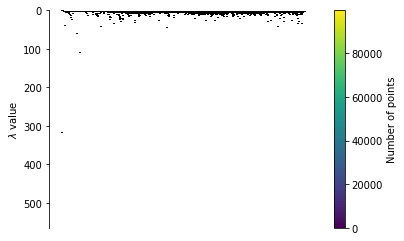

In [27]:
import seaborn as sns
#clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('deep', 8))
clusterer.condensed_tree_.plot()

In [ ]:
df_topic_info = topic_model.get_topic_info()
#df_topic_info.to_csv(f'../raw_data/embeddings/berttopic/BERTopicInfo_{str(file_name)}.csv', header=True, index=False, encoding='utf-8')
df_topic_info

In [ ]:
#np.savetxt("../raw_data/embeddings/merda_doc_topics.csv", clusterer.labels_, delimiter=",")
x = 0
for l in clusterer.labels_:
    #if l > x:
    if l == -1:
        x += 1
        #x = l
print(x)

In [ ]:
#df_hdbscan.to_csv(f'../raw_data/embeddings/porra.csv', header=True, index=False, encoding='utf-8')
tree = clusterer.condensed_tree_
clusters = tree._select_clusters()
print(len(clusters))

In [ ]:
bert_model = topic_model

clusterer = bert_model.hdbscan_model
tree = clusterer.condensed_tree_
clusters = tree._select_clusters()

number_of_topics = len(clusters)
print(number_of_topics)

relevant_columns = ['topic', 'document', 'lambda_val']
df_rel_docs = pd.DataFrame(columns=relevant_columns)

for i in range(-1, number_of_topics):
    cluster_id = clusters[i]
    condensed_tree = tree
    topic_name = bert_model.topic_names[i]
    
    print(topic_name)
    
    result_points = np.array([])
    result_points_val = np.array([])

        
    raw_tree = condensed_tree._raw_tree
    
    # Just the cluster elements of the tree, excluding singleton points
    #cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(raw_tree, cluster_id)
    print(cluster_id)
    
    #print(type(leaves))
    print(len(leaves))
    #print(leaves[0])
    
    #print(raw_tree.shape)
    
    #np.save('../raw_data/porra.npy', raw_tree)
    #for line in raw_tree:
        #print(line[1])
        #(raw_tree['parent'] == leaf)
    
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf) 
    
    porra = 0
    for leaf in leaves:
        #print(leaf)
        porra += 1
        #max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        #points = raw_tree['child'][(raw_tree['parent'] == leaf) & (raw_tree['lambda_val'] == max_lambda)]
        #points_val = raw_tree['lambda_val'][(raw_tree['parent'] == leaf) & (raw_tree['lambda_val'] == max_lambda)]
        '''points = raw_tree['child'][(raw_tree['parent'] == leaf)]
        points_val = raw_tree['lambda_val'][(raw_tree['parent'] == leaf)]
        result_points = np.hstack((result_points, points))
        result_points_val = np.hstack((result_points_val, points_val))
    '''
    print(porra)
    break


## Similarity between documents

In [ ]:
import numpy as np
import pandas as pd
docs_similarity = np.load('../raw_data/proj_final/similarity/0_cosine_similarity.npy')
ind = 0
for sim in docs_similarity:
    ind += 1
    print(sim)
    if ind > 5:
        break

print(' ********** ')
print(docs_similarity[len(docs_similarity)-5])
print(docs_similarity[len(docs_similarity)-4])
print(docs_similarity[len(docs_similarity)-3])
print(docs_similarity[len(docs_similarity)-2])
print(docs_similarity[len(docs_similarity)-1])

In [ ]:
type(docs_similarity)

In [ ]:
%%time
sim_columns = ['document', 'most_similar_doc', 'higher_cosine_similarity']
df_most_sim = pd.DataFrame(columns=sim_columns)
most_sim_doc_pair = ['-1_-1']
print_calc = 0
for i in range(0, 99777):
    print_calc += 1
    doc_similarity = np.load(f'../raw_data/proj_final/similarity/{i}_cosine_similarity.npy')
    doc_id = i
    higher_sim = -1
    doc_id_sim = -1
    for j, sim in enumerate(doc_similarity):
        if i != j:
            doc_pair = f'{j}_{i}'
            if (doc_similarity[j] > higher_sim) and (doc_pair not in most_sim_doc_pair):
                higher_sim = doc_similarity[j]
                doc_id_sim = j
    new_doc = {}
    new_doc['document'] = doc_id
    new_doc['most_similar_doc'] = doc_id_sim
    new_doc['higher_cosine_similarity'] = higher_sim
    df_most_sim = df_most_sim.append(new_doc, ignore_index=True)
    most_sim_doc_pair.append(f'{doc_id}_{doc_id_sim}')
    if print_calc > 1000:
        print(i)
        print_calc = 0
df_most_sim.to_csv('../raw_data/proj_final/most_similar_docs.csv', header=True, index=False, encoding='utf-8')
del df_most_sim

In [17]:
df_most_sim = pd.read_csv('../raw_data/proj_final/most_similar_docs.csv')
df_most_sim = df_most_sim.sort_values(by=['higher_cosine_similarity'], ascending=False).copy()

In [18]:
df_most_sim = df_most_sim[df_most_sim['higher_cosine_similarity'] >= 0.6]
df_most_sim

,document,most_similar_doc,higher_cosine_similarity
8529,8529.0,12853.0,1.000000
44767,44767.0,44787.0,1.000000
60443,60443.0,60789.0,1.000000
4046,4046.0,4072.0,1.000000
23646,23646.0,23676.0,1.000000
...,...,...,...
69022,69022.0,62955.0,0.600067
34861,34861.0,96086.0,0.600053
4884,4884.0,31243.0,0.600036
27049,27049.0,73711.0,0.600026


In [23]:
#x = df_most_sim.groupby(by=["most_similar_doc"])['document'].count().mean()
#x = df_most_sim.groupby(by=["most_similar_doc"])['document', 'higher_cosine_similarity'].count().mean()
x = df_most_sim.groupby(by=["most_similar_doc"])['document'].count()
x = x.to_frame().reset_index()
# x['document'].sum()
x.sort_values(by=['document'], ascending=False).head(3)

,most_similar_doc,document
33105,69845.0,15
10637,23427.0,15
22532,48349.0,15


In [8]:
#x[x['document'] >= 9]

In [24]:
doc_sim = np.load('../raw_data/proj_final/similarity/69845_cosine_similarity.npy')
doc_sim[28672]

0.33987612

In [25]:
doc_sim = np.load('../raw_data/proj_final/similarity/23427_cosine_similarity.npy')
doc_sim[48349]

0.78258556